Определение перспективного тарифа для телеком-компании
Описание тарифов

Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

Описание файлов

users

Таблица users (информация о пользователях):
user_id — уникальный идентификатор пользователя
first_name — имя пользователя
last_name — фамилия пользователя
age — возраст пользователя (годы)
reg_date — дата подключения тарифа (день, месяц, год)
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
city — город проживания пользователя
tarif — название тарифного плана

calls

Таблица calls (информация о звонках):
id — уникальный номер звонка
call_date — дата звонка
duration — длительность звонка в минутах
user_id — идентификатор пользователя, сделавшего звонок

messages

Таблица messages (информация о сообщениях):
id — уникальный номер сообщения
message_date — дата сообщения
user_id — идентификатор пользователя, отправившего сообщение

Internet

Таблица internet (информация об интернет-сессиях):
id — уникальный номер сессии
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
session_date — дата интернет-сессии
user_id — идентификатор пользователя

tariffs

Таблица tariffs (информация о тарифах):
tariff_name — название тарифа
rub_monthly_fee — ежемесячная абонентская плата в рублях
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
messages_included — количество сообщений в месяц, включённых в абонентскую плату
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
rub_per_message — стоимость отправки сообщения сверх тарифного пакета
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Открытие данных

In [1]:
import pandas as pd
import math
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Анализ таблицы users(информация о пользователях)

In [3]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Проверка на пропущенные значения и дубликаты

In [4]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Пропуски только в столбце churn_date, они значат, что тариф еще действовал в момент выгрузки датасета. Не будем заполнять эти пустые значения

In [5]:
users.duplicated().sum()

0

Дубликатов нет

In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Замена типа данных в столбце reg_date

In [7]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Анализ таблицы calls

In [8]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


Проверка на пустые значения и дубликаты

In [9]:
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [10]:
calls.duplicated().sum()

0

In [11]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Замена типа данных в столбце call_date

In [12]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

Проверка, есть ли звонки с отрицательной продолжительностью

In [13]:
calls.query('duration < 0')

,id,call_date,duration,user_id


обработка таблицы messages

In [14]:
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [15]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Замена типа данных в столбце message_date

In [16]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

обработка таблицы internet

In [17]:
internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


Обнаружен столбец, полностью повторяющий индексы, избавимся от этого столбца

In [18]:
internet = internet.loc[:,['id', 'mb_used', 'session_date', 'user_id']]
internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


проверка, есть ли отрицательные значения в столбце mb_used

In [19]:
internet.query('mb_used < 0')

,id,mb_used,session_date,user_id


In [20]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


замена типа данных в столбце session_date

In [21]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

Обработка таблицы с тарифами

In [22]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Количество сделанных звонков и израсходованных минут разговора по месяцам

In [23]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [24]:
calls['month'] = calls['call_date'].dt.month
calls

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,12
202603,1499_216,2018-10-18,18.83,1499,10
202604,1499_217,2018-11-10,10.81,1499,11
202605,1499_218,2018-10-06,4.27,1499,10


In [25]:
tarifs_for_users = users.loc[:,['user_id', 'tariff']]
tarifs_for_users

,user_id,tariff
0,1000,ultra
1,1001,smart
2,1002,smart
3,1003,ultra
4,1004,ultra
...,...,...
495,1495,ultra
496,1496,smart
497,1497,smart
498,1498,smart


In [26]:
calls_group = calls.groupby(['user_id', 'month'], as_index=False).agg({'duration':['count', 'sum']})
calls_group

user_id month duration        
                      count     sum
0       1000     5       22  150.06
1       1000     6       43  158.90
2       1000     7       47  318.80
3       1000     8       52  389.87
4       1000     9       58  440.14
...      ...   ...      ...     ...
3169    1498    10       41  232.63
3170    1499     9        9   64.65
3171    1499    10       68  429.91
3172    1499    11       74  576.50
3173    1499    12       69  465.16

[3174 rows x 4 columns]

In [27]:
sheet = list(tarifs_for_users.query('tariff == "ultra"')['user_id'])
sheet

[1000,
 1003,
 1004,
 1013,
 1016,
 1018,
 1019,
 1021,
 1024,
 1028,
 1039,
 1048,
 1049,
 1050,
 1053,
 1057,
 1060,
 1063,
 1078,
 1080,
 1081,
 1084,
 1085,
 1089,
 1090,
 1091,
 1094,
 1096,
 1097,
 1099,
 1104,
 1106,
 1120,
 1122,
 1124,
 1126,
 1128,
 1143,
 1148,
 1150,
 1151,
 1152,
 1156,
 1165,
 1166,
 1167,
 1168,
 1180,
 1182,
 1185,
 1192,
 1196,
 1200,
 1201,
 1203,
 1208,
 1222,
 1225,
 1226,
 1231,
 1234,
 1240,
 1243,
 1245,
 1253,
 1254,
 1255,
 1257,
 1259,
 1265,
 1270,
 1271,
 1272,
 1273,
 1276,
 1277,
 1281,
 1289,
 1292,
 1294,
 1300,
 1303,
 1304,
 1309,
 1310,
 1318,
 1325,
 1328,
 1330,
 1331,
 1333,
 1335,
 1336,
 1341,
 1343,
 1344,
 1346,
 1347,
 1348,
 1349,
 1350,
 1352,
 1356,
 1360,
 1361,
 1363,
 1364,
 1367,
 1369,
 1375,
 1377,
 1379,
 1380,
 1381,
 1382,
 1385,
 1391,
 1392,
 1396,
 1397,
 1399,
 1402,
 1403,
 1405,
 1412,
 1415,
 1416,
 1424,
 1430,
 1436,
 1440,
 1442,
 1452,
 1453,
 1455,
 1458,
 1461,
 1463,
 1466,
 1467,
 1469,
 1471,
 1473,

In [28]:
def tariff(value, sheet):
    if value in sheet:
        return 'ultra'
    else:
        return 'smart'

In [29]:
calls_group['tarif'] = calls_group['user_id'].apply(tariff, args=(sheet,))
calls_group

user_id month duration          tarif
                      count     sum       
0       1000     5       22  150.06  ultra
1       1000     6       43  158.90  ultra
2       1000     7       47  318.80  ultra
3       1000     8       52  389.87  ultra
4       1000     9       58  440.14  ultra
...      ...   ...      ...     ...    ...
3169    1498    10       41  232.63  smart
3170    1499     9        9   64.65  smart
3171    1499    10       68  429.91  smart
3172    1499    11       74  576.50  smart
3173    1499    12       69  465.16  smart

[3174 rows x 5 columns]

Количество отправленных сообщений по месяцам

In [30]:
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [31]:
messages['month'] = messages['message_date'].dt.month
messages

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


In [32]:
messages_group = messages.groupby(['user_id','month'],as_index=False).agg({'id':'count'})
messages_group.columns = ['user_id', 'month', 'messages']
messages_group

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


объем израсходованного трафика по месяцам

In [33]:
internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


In [34]:
internet['month'] = internet['session_date'].dt.month
internet

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499,10
149392,1499_153,490.13,2018-12-14,1499,12
149393,1499_154,0.00,2018-10-27,1499,10
149394,1499_155,1246.32,2018-11-26,1499,11


In [35]:
internet_group = internet.groupby(['user_id', 'month'],as_index=False).agg({'mb_used':'sum'})
internet_group['gb_used'] = round(internet_group['mb_used'] / 1024, 2)
internet_group

,user_id,month,mb_used,gb_used
0,1000,5,2253.49,2.20
1,1000,6,23233.77,22.69
2,1000,7,14003.64,13.68
3,1000,8,14055.93,13.73
4,1000,9,14568.91,14.23
...,...,...,...,...
3198,1498,10,20579.36,20.10
3199,1499,9,1845.75,1.80
3200,1499,10,17788.51,17.37
3201,1499,11,17963.31,17.54


Добавление в каждую таблицу столбец с тарифом

In [36]:
messages_group['tarif'] = messages_group['user_id'].apply(tariff, args=(sheet,))
internet_group['tarif'] = internet_group['user_id'].apply(tariff, args=(sheet,))

Добавление в сгруппированные таблицы оплаченного числа минут, сообщений и гб интернета

In [37]:
def minutes(tarif):
    if tarif == 'smart':
        return 500
    else:
        return 3000

In [38]:
calls_group

user_id month duration          tarif
                      count     sum       
0       1000     5       22  150.06  ultra
1       1000     6       43  158.90  ultra
2       1000     7       47  318.80  ultra
3       1000     8       52  389.87  ultra
4       1000     9       58  440.14  ultra
...      ...   ...      ...     ...    ...
3169    1498    10       41  232.63  smart
3170    1499     9        9   64.65  smart
3171    1499    10       68  429.91  smart
3172    1499    11       74  576.50  smart
3173    1499    12       69  465.16  smart

[3174 rows x 5 columns]

In [39]:
calls_group['paid_minutes'] = calls_group['tarif'].apply(minutes)
calls_group

user_id month duration          tarif paid_minutes
                      count     sum                    
0       1000     5       22  150.06  ultra         3000
1       1000     6       43  158.90  ultra         3000
2       1000     7       47  318.80  ultra         3000
3       1000     8       52  389.87  ultra         3000
4       1000     9       58  440.14  ultra         3000
...      ...   ...      ...     ...    ...          ...
3169    1498    10       41  232.63  smart          500
3170    1499     9        9   64.65  smart          500
3171    1499    10       68  429.91  smart          500
3172    1499    11       74  576.50  smart          500
3173    1499    12       69  465.16  smart          500

[3174 rows x 6 columns]

Необходимо округлить вверх сумму всех минут, проговоренных пользователем за месяц, таковы правила компании

In [40]:
def high_round(value):
    new_value = int(value) + 1
    return new_value

In [41]:
calls_group['minutes_for_company'] = calls_group['duration'].loc[:,'sum'].apply(np.ceil)
calls_group

user_id month duration          tarif paid_minutes minutes_for_company
                      count     sum                                        
0       1000     5       22  150.06  ultra         3000               151.0
1       1000     6       43  158.90  ultra         3000               159.0
2       1000     7       47  318.80  ultra         3000               319.0
3       1000     8       52  389.87  ultra         3000               390.0
4       1000     9       58  440.14  ultra         3000               441.0
...      ...   ...      ...     ...    ...          ...                 ...
3169    1498    10       41  232.63  smart          500               233.0
3170    1499     9        9   64.65  smart          500                65.0
3171    1499    10       68  429.91  smart          500               430.0
3172    1499    11       74  576.50  smart          500               577.0
3173    1499    12       69  465.16  smart          500               466.0

[3174 rows x 7 columns]

In [42]:
calls_group['minutes_over_tariff'] = calls_group['minutes_for_company'] - calls_group['paid_minutes']
calls_group

user_id month duration          tarif paid_minutes minutes_for_company  \
                      count     sum                                           
0       1000     5       22  150.06  ultra         3000               151.0   
1       1000     6       43  158.90  ultra         3000               159.0   
2       1000     7       47  318.80  ultra         3000               319.0   
3       1000     8       52  389.87  ultra         3000               390.0   
4       1000     9       58  440.14  ultra         3000               441.0   
...      ...   ...      ...     ...    ...          ...                 ...   
3169    1498    10       41  232.63  smart          500               233.0   
3170    1499     9        9   64.65  smart          500                65.0   
3171    1499    10       68  429.91  smart          500               430.0   
3172    1499    11       74  576.50  smart          500               577.0   
3173    1499    12       69  465.16  smart          500               466.0   

     minutes_over_tariff  
                          
0                -2849.0  
1                -2841.0  
2                -2681.0  
3                -2610.0  
4                -2559.0  
...                  ...  
3169              -267.0  
3170              -435.0  
3171               -70.0  
3172                77.0  
3173               -34.0  

[3174 rows x 8 columns]

In [43]:
def transform(value):
    if value > 0:
        return value
    else:
        return 0

In [44]:
calls_group['minutes_over_tariff'] = calls_group['minutes_over_tariff'].apply(transform)
calls_group

user_id month duration          tarif paid_minutes minutes_for_company  \
                      count     sum                                           
0       1000     5       22  150.06  ultra         3000               151.0   
1       1000     6       43  158.90  ultra         3000               159.0   
2       1000     7       47  318.80  ultra         3000               319.0   
3       1000     8       52  389.87  ultra         3000               390.0   
4       1000     9       58  440.14  ultra         3000               441.0   
...      ...   ...      ...     ...    ...          ...                 ...   
3169    1498    10       41  232.63  smart          500               233.0   
3170    1499     9        9   64.65  smart          500                65.0   
3171    1499    10       68  429.91  smart          500               430.0   
3172    1499    11       74  576.50  smart          500               577.0   
3173    1499    12       69  465.16  smart          500               466.0   

     minutes_over_tariff  
                          
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
...                  ...  
3169                 0.0  
3170                 0.0  
3171                 0.0  
3172                77.0  
3173                 0.0  

[3174 rows x 8 columns]

In [45]:
def overprice_calls(tarif):
    if tarif == 'smart':
        overprice_per_minutes = 3
    else:
        overprice_per_minutes = 1
    return overprice_per_minutes

In [46]:
calls_group['overprice_per_minutes'] = calls_group['tarif'].apply(overprice_calls)
calls_group['final_overprice_for_calls'] = calls_group['minutes_over_tariff'] * calls_group['overprice_per_minutes']
calls_group

user_id month duration          tarif paid_minutes minutes_for_company  \
                      count     sum                                           
0       1000     5       22  150.06  ultra         3000               151.0   
1       1000     6       43  158.90  ultra         3000               159.0   
2       1000     7       47  318.80  ultra         3000               319.0   
3       1000     8       52  389.87  ultra         3000               390.0   
4       1000     9       58  440.14  ultra         3000               441.0   
...      ...   ...      ...     ...    ...          ...                 ...   
3169    1498    10       41  232.63  smart          500               233.0   
3170    1499     9        9   64.65  smart          500                65.0   
3171    1499    10       68  429.91  smart          500               430.0   
3172    1499    11       74  576.50  smart          500               577.0   
3173    1499    12       69  465.16  smart          500               466.0   

     minutes_over_tariff overprice_per_minutes final_overprice_for_calls  
                                                                          
0                    0.0                     1                       0.0  
1                    0.0                     1                       0.0  
2                    0.0                     1                       0.0  
3                    0.0                     1                       0.0  
4                    0.0                     1                       0.0  
...                  ...                   ...                       ...  
3169                 0.0                     3                       0.0  
3170                 0.0                     3                       0.0  
3171                 0.0                     3                       0.0  
3172                77.0                     3                     231.0  
3173                 0.0                     3                       0.0  

[3174 rows x 10 columns]

In [47]:
calls_group_final = calls_group.loc[:, ['user_id', 'month', 'minutes_over_tariff', 'final_overprice_for_calls']]
calls_group_final

,user_id,month,minutes_over_tariff,final_overprice_for_calls
,,,,
0,1000,5,0.0,0.0
1,1000,6,0.0,0.0
2,1000,7,0.0,0.0
3,1000,8,0.0,0.0
4,1000,9,0.0,0.0
...,...,...,...,...
3169,1498,10,0.0,0.0
3170,1499,9,0.0,0.0
3171,1499,10,0.0,0.0


Расчет сообщений и интернета вне тарифа

In [48]:
messages_group

,user_id,month,messages,tarif
0,1000,5,22,ultra
1,1000,6,60,ultra
2,1000,7,75,ultra
3,1000,8,81,ultra
4,1000,9,57,ultra
...,...,...,...,...
2712,1498,10,42,smart
2713,1499,9,11,smart
2714,1499,10,48,smart
2715,1499,11,59,smart


In [49]:
def paid_messages(tarif):
    if tarif == 'ultra':
        return 1000
    else:
        return 50

In [50]:
messages_group['paid_messages'] = messages_group['tarif'].apply(paid_messages)
messages_group

,user_id,month,messages,tarif,paid_messages
0,1000,5,22,ultra,1000
1,1000,6,60,ultra,1000
2,1000,7,75,ultra,1000
3,1000,8,81,ultra,1000
4,1000,9,57,ultra,1000
...,...,...,...,...,...
2712,1498,10,42,smart,50
2713,1499,9,11,smart,50
2714,1499,10,48,smart,50
2715,1499,11,59,smart,50


In [51]:
messages_group['message_over_tarif'] = (messages_group['messages'] - messages_group['paid_messages']).apply(transform)
messages_group

,user_id,month,messages,tarif,paid_messages,message_over_tarif
0,1000,5,22,ultra,1000,0
1,1000,6,60,ultra,1000,0
2,1000,7,75,ultra,1000,0
3,1000,8,81,ultra,1000,0
4,1000,9,57,ultra,1000,0
...,...,...,...,...,...,...
2712,1498,10,42,smart,50,0
2713,1499,9,11,smart,50,0
2714,1499,10,48,smart,50,0
2715,1499,11,59,smart,50,9


In [52]:
def overprice_messages(tarif):
    if tarif == 'smart':
        overprice_per_messages = 3
    else:
        overprice_per_messages = 1
    return overprice_per_messages

In [53]:
messages_group['overprice_per_messages'] = messages_group['tarif'].apply(overprice_messages)
messages_group['final_overprice_for_messages'] = messages_group['message_over_tarif'] * messages_group['overprice_per_messages']
messages_group

,user_id,month,messages,tarif,paid_messages,message_over_tarif,overprice_per_messages,final_overprice_for_messages
0,1000,5,22,ultra,1000,0,1,0
1,1000,6,60,ultra,1000,0,1,0
2,1000,7,75,ultra,1000,0,1,0
3,1000,8,81,ultra,1000,0,1,0
4,1000,9,57,ultra,1000,0,1,0
...,...,...,...,...,...,...,...,...
2712,1498,10,42,smart,50,0,3,0
2713,1499,9,11,smart,50,0,3,0
2714,1499,10,48,smart,50,0,3,0
2715,1499,11,59,smart,50,9,3,27


In [54]:
messages_group_final = messages_group.loc[:,['user_id', 'month', 'message_over_tarif', 'final_overprice_for_messages']]
messages_group_final

,user_id,month,message_over_tarif,final_overprice_for_messages
0,1000,5,0,0
1,1000,6,0,0
2,1000,7,0,0
3,1000,8,0,0
4,1000,9,0,0
...,...,...,...,...
2712,1498,10,0,0
2713,1499,9,0,0
2714,1499,10,0,0
2715,1499,11,9,27


In [55]:
internet_group

,user_id,month,mb_used,gb_used,tarif
0,1000,5,2253.49,2.20,ultra
1,1000,6,23233.77,22.69,ultra
2,1000,7,14003.64,13.68,ultra
3,1000,8,14055.93,13.73,ultra
4,1000,9,14568.91,14.23,ultra
...,...,...,...,...,...
3198,1498,10,20579.36,20.10,smart
3199,1499,9,1845.75,1.80,smart
3200,1499,10,17788.51,17.37,smart
3201,1499,11,17963.31,17.54,smart


In [56]:
internet_group['gb_used_for_company'] = internet_group['gb_used'].apply(int) + 1
internet_group

,user_id,month,mb_used,gb_used,tarif,gb_used_for_company
0,1000,5,2253.49,2.20,ultra,3
1,1000,6,23233.77,22.69,ultra,23
2,1000,7,14003.64,13.68,ultra,14
3,1000,8,14055.93,13.73,ultra,14
4,1000,9,14568.91,14.23,ultra,15
...,...,...,...,...,...,...
3198,1498,10,20579.36,20.10,smart,21
3199,1499,9,1845.75,1.80,smart,2
3200,1499,10,17788.51,17.37,smart,18
3201,1499,11,17963.31,17.54,smart,18


In [57]:
def paid_gigabytes(tarif):
    if tarif == 'smart':
        return 15
    else:
        return 30

In [58]:
internet_group['paid_gigabytes'] = internet_group['tarif'].apply(paid_gigabytes)
internet_group

,user_id,month,mb_used,gb_used,tarif,gb_used_for_company,paid_gigabytes
0,1000,5,2253.49,2.20,ultra,3,30
1,1000,6,23233.77,22.69,ultra,23,30
2,1000,7,14003.64,13.68,ultra,14,30
3,1000,8,14055.93,13.73,ultra,14,30
4,1000,9,14568.91,14.23,ultra,15,30
...,...,...,...,...,...,...,...
3198,1498,10,20579.36,20.10,smart,21,15
3199,1499,9,1845.75,1.80,smart,2,15
3200,1499,10,17788.51,17.37,smart,18,15
3201,1499,11,17963.31,17.54,smart,18,15


In [59]:
internet_group['gb_over_tarif'] = (internet_group['gb_used_for_company'] - internet_group['paid_gigabytes']).apply(transform)
internet_group

,user_id,month,mb_used,gb_used,tarif,gb_used_for_company,paid_gigabytes,gb_over_tarif
0,1000,5,2253.49,2.20,ultra,3,30,0
1,1000,6,23233.77,22.69,ultra,23,30,0
2,1000,7,14003.64,13.68,ultra,14,30,0
3,1000,8,14055.93,13.73,ultra,14,30,0
4,1000,9,14568.91,14.23,ultra,15,30,0
...,...,...,...,...,...,...,...,...
3198,1498,10,20579.36,20.10,smart,21,15,6
3199,1499,9,1845.75,1.80,smart,2,15,0
3200,1499,10,17788.51,17.37,smart,18,15,3
3201,1499,11,17963.31,17.54,smart,18,15,3


In [60]:
def overprice_for_internet(tarif):
    if tarif == 'smart':
        overprice_per_gb = 200
    else:
        overprice_per_gb = 150
    return overprice_per_gb

In [61]:
internet_group['overprice_per_gb'] = internet_group['tarif'].apply(overprice_for_internet)
internet_group['final_overprice_internet'] = internet_group['gb_over_tarif'] * internet_group['overprice_per_gb']
internet_group

,user_id,month,mb_used,gb_used,tarif,gb_used_for_company,paid_gigabytes,gb_over_tarif,overprice_per_gb,final_overprice_internet
0,1000,5,2253.49,2.20,ultra,3,30,0,150,0
1,1000,6,23233.77,22.69,ultra,23,30,0,150,0
2,1000,7,14003.64,13.68,ultra,14,30,0,150,0
3,1000,8,14055.93,13.73,ultra,14,30,0,150,0
4,1000,9,14568.91,14.23,ultra,15,30,0,150,0
...,...,...,...,...,...,...,...,...,...,...
3198,1498,10,20579.36,20.10,smart,21,15,6,200,1200
3199,1499,9,1845.75,1.80,smart,2,15,0,200,0
3200,1499,10,17788.51,17.37,smart,18,15,3,200,600
3201,1499,11,17963.31,17.54,smart,18,15,3,200,600


In [62]:
internet_group_final = internet_group.loc[:, ['user_id', 'month', 'gb_over_tarif', 'final_overprice_internet']]
internet_group_final

,user_id,month,gb_over_tarif,final_overprice_internet
0,1000,5,0,0
1,1000,6,0,0
2,1000,7,0,0
3,1000,8,0,0
4,1000,9,0,0
...,...,...,...,...
3198,1498,10,6,1200
3199,1499,9,0,0
3200,1499,10,3,600
3201,1499,11,3,600


In [63]:
helpi = messages_group_final.merge(internet_group_final, on=['user_id', 'month'], how='outer')
helpi

,user_id,month,message_over_tarif,final_overprice_for_messages,gb_over_tarif,final_overprice_internet
0,1000,5,0.0,0.0,0.0,0.0
1,1000,6,0.0,0.0,0.0,0.0
2,1000,7,0.0,0.0,0.0,0.0
3,1000,8,0.0,0.0,0.0,0.0
4,1000,9,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
3209,1494,8,NaN,NaN,0.0,0.0
3210,1494,9,NaN,NaN,2.0,400.0
3211,1494,10,NaN,NaN,3.0,600.0
3212,1494,11,NaN,NaN,3.0,600.0


In [64]:
final_group = calls_group_final.merge(helpi, on=['user_id', 'month'], how='outer')
final_group = final_group.fillna(0)
final_group

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,user_id,month,"(user_id, )","(month, )","(minutes_over_tariff, )","(final_overprice_for_calls, )",message_over_tarif,final_overprice_for_messages,gb_over_tarif,final_overprice_internet
0,1000,5,1000.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1000,6,1000.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1000,7,1000.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1000,8,1000.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1000,9,1000.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,0.0,0.0,0.0,0.0,2.0,400.0
3210,1489,10,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1000.0
3211,1489,11,0.0,0.0,0.0,0.0,0.0,0.0,3.0,600.0
3212,1489,12,0.0,0.0,0.0,0.0,0.0,0.0,2.0,400.0


In [65]:
final_group.user_id.nunique()

498

In [66]:
final_group.columns

Index([                        'user_id',                           'month',
                         ('user_id', ''),                     ('month', ''),
             ('minutes_over_tariff', ''), ('final_overprice_for_calls', ''),
                    'message_over_tarif',    'final_overprice_for_messages',
                         'gb_over_tarif',        'final_overprice_internet'],
      dtype='object')

In [67]:
final_group = final_group.loc[:,
            ['user_id', 'month', ('final_overprice_for_calls', ''), 'final_overprice_for_messages', 'final_overprice_internet']
                             ]
final_group

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,user_id,month,"(final_overprice_for_calls, )",final_overprice_for_messages,final_overprice_internet
0,1000,5,0.0,0.0,0.0
1,1000,6,0.0,0.0,0.0
2,1000,7,0.0,0.0,0.0
3,1000,8,0.0,0.0,0.0
4,1000,9,0.0,0.0,0.0
...,...,...,...,...,...
3209,1489,9,0.0,0.0,400.0
3210,1489,10,0.0,0.0,1000.0
3211,1489,11,0.0,0.0,600.0
3212,1489,12,0.0,0.0,400.0


In [68]:
final_group['tarif'] = final_group['user_id'].apply(tariff, args=(sheet,))
final_group

,user_id,month,"(final_overprice_for_calls, )",final_overprice_for_messages,final_overprice_internet,tarif
0,1000,5,0.0,0.0,0.0,ultra
1,1000,6,0.0,0.0,0.0,ultra
2,1000,7,0.0,0.0,0.0,ultra
3,1000,8,0.0,0.0,0.0,ultra
4,1000,9,0.0,0.0,0.0,ultra
...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,400.0,smart
3210,1489,10,0.0,0.0,1000.0,smart
3211,1489,11,0.0,0.0,600.0,smart
3212,1489,12,0.0,0.0,400.0,smart


In [69]:
def abonent_payments(tarif):
    if tarif == 'smart':
        return 550
    else:
        return 1950

In [70]:
final_group['abonent_payments'] = final_group['tarif'].apply(abonent_payments)
final_group

,user_id,month,"(final_overprice_for_calls, )",final_overprice_for_messages,final_overprice_internet,tarif,abonent_payments
0,1000,5,0.0,0.0,0.0,ultra,1950
1,1000,6,0.0,0.0,0.0,ultra,1950
2,1000,7,0.0,0.0,0.0,ultra,1950
3,1000,8,0.0,0.0,0.0,ultra,1950
4,1000,9,0.0,0.0,0.0,ultra,1950
...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,400.0,smart,550
3210,1489,10,0.0,0.0,1000.0,smart,550
3211,1489,11,0.0,0.0,600.0,smart,550
3212,1489,12,0.0,0.0,400.0,smart,550


Расчет стоимости прибыли с клиента для компании

In [71]:
final_group['company_profit'] = final_group[('final_overprice_for_calls','')] + final_group[
                    'final_overprice_for_messages'] + final_group['final_overprice_internet'] + final_group['abonent_payments']
final_group

,user_id,month,"(final_overprice_for_calls, )",final_overprice_for_messages,final_overprice_internet,tarif,abonent_payments,company_profit
0,1000,5,0.0,0.0,0.0,ultra,1950,1950.0
1,1000,6,0.0,0.0,0.0,ultra,1950,1950.0
2,1000,7,0.0,0.0,0.0,ultra,1950,1950.0
3,1000,8,0.0,0.0,0.0,ultra,1950,1950.0
4,1000,9,0.0,0.0,0.0,ultra,1950,1950.0
...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,400.0,smart,550,950.0
3210,1489,10,0.0,0.0,1000.0,smart,550,1550.0
3211,1489,11,0.0,0.0,600.0,smart,550,1150.0
3212,1489,12,0.0,0.0,400.0,smart,550,950.0


In [72]:
final_group['company_profit'].describe()

count    3214.000000
mean     1507.409770
std       793.008233
min       550.000000
25%       748.000000
50%      1568.000000
75%      1950.000000
max      6614.000000
Name: company_profit, dtype: float64

Описание поведения исходя из выборки

In [73]:
calls_group

user_id month duration          tarif paid_minutes minutes_for_company  \
                      count     sum                                           
0       1000     5       22  150.06  ultra         3000               151.0   
1       1000     6       43  158.90  ultra         3000               159.0   
2       1000     7       47  318.80  ultra         3000               319.0   
3       1000     8       52  389.87  ultra         3000               390.0   
4       1000     9       58  440.14  ultra         3000               441.0   
...      ...   ...      ...     ...    ...          ...                 ...   
3169    1498    10       41  232.63  smart          500               233.0   
3170    1499     9        9   64.65  smart          500                65.0   
3171    1499    10       68  429.91  smart          500               430.0   
3172    1499    11       74  576.50  smart          500               577.0   
3173    1499    12       69  465.16  smart          500               466.0   

     minutes_over_tariff overprice_per_minutes final_overprice_for_calls  
                                                                          
0                    0.0                     1                       0.0  
1                    0.0                     1                       0.0  
2                    0.0                     1                       0.0  
3                    0.0                     1                       0.0  
4                    0.0                     1                       0.0  
...                  ...                   ...                       ...  
3169                 0.0                     3                       0.0  
3170                 0.0                     3                       0.0  
3171                 0.0                     3                       0.0  
3172                77.0                     3                     231.0  
3173                 0.0                     3                       0.0  

[3174 rows x 10 columns]

In [74]:
calls_group['minutes'] = calls_group[('duration', 'sum')]

Распределение минут, потраченных пользователями тарифа смарт в каждом месяце

Text(0.5, 1.0, 'Smart minutes distribution')

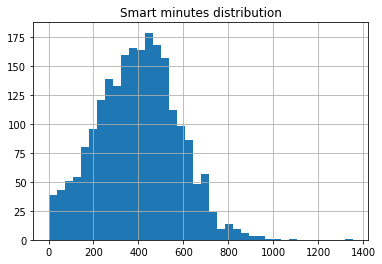

In [75]:
calls_group.loc[(calls_group['tarif'] == 'smart'), 'minutes'].hist(bins=38)
plt.title('Smart minutes distribution')

In [76]:
calls_group.loc[(calls_group['tarif'] == 'smart'), 'minutes'].describe()

count    2223.000000
mean      395.491606
std       179.032472
min         0.000000
25%       268.305000
50%       398.790000
75%       515.360000
max      1354.220000
Name: minutes, dtype: float64

Расчет дисперсии, стандартного отклонения и среднего для тарифа смарт

In [77]:
variance_smart = np.var(calls_group.loc[(calls_group['tarif'] == 'smart'), 'minutes'], ddof=1)
variance_smart

32052.625910876148

In [78]:
std_smart = math.sqrt(variance_smart)
std_smart

179.03247166610907

In [79]:
mean_smart = calls_group.loc[(calls_group['tarif'] == 'smart'), 'minutes'].mean()
mean_smart

395.4916059379217

Распределение минут, потраченных пользователями тарифа ультра в каждом месяце

Text(0.5, 1.0, 'Ultra minutes distribution')

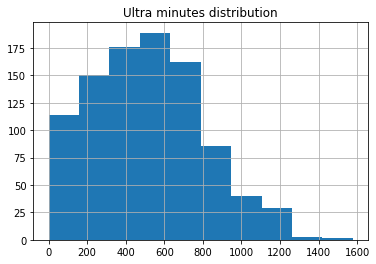

In [80]:
calls_group.loc[(calls_group['tarif'] == 'ultra'), 'minutes'].hist(bins=10)
plt.title('Ultra minutes distribution')

In [81]:
calls_group.loc[(calls_group['tarif'] == 'ultra'), 'minutes'].describe()

count     951.000000
mean      514.839327
std       289.832022
min         0.000000
25%       291.730000
50%       497.890000
75%       714.630000
max      1578.060000
Name: minutes, dtype: float64

Расчет дисперсии, стандартного отклонения и среднего для пользователей тарифа ультра

In [82]:
variance_ultra = np.var(calls_group.loc[(calls_group['tarif'] == 'ultra'), 'minutes'], ddof=1)
variance_ultra

84002.60126038875

In [83]:
std_ultra = math.sqrt(variance_ultra)
std_ultra

289.8320224895599

In [84]:
mean_ultra = calls_group.loc[(calls_group['tarif'] == 'ultra'), 'minutes'].mean()
mean_ultra

514.8393270241851

Гистограмма для тарифа смарт напоминает нормальное распределение, но все же немного скошена влево об этом говорит то, что медиана больше среднего, значит многие пользователи этого тарифа тратят меньше среднего минут

Гистограма для тарифа ультра скошена вправо, это видно из гистограмы и из того, что медиана меньше среднего, значит многие пользователи используют больше среднего минут

Анализ тарифов по смс

In [85]:
messages_group

,user_id,month,messages,tarif,paid_messages,message_over_tarif,overprice_per_messages,final_overprice_for_messages
0,1000,5,22,ultra,1000,0,1,0
1,1000,6,60,ultra,1000,0,1,0
2,1000,7,75,ultra,1000,0,1,0
3,1000,8,81,ultra,1000,0,1,0
4,1000,9,57,ultra,1000,0,1,0
...,...,...,...,...,...,...,...,...
2712,1498,10,42,smart,50,0,3,0
2713,1499,9,11,smart,50,0,3,0
2714,1499,10,48,smart,50,0,3,0
2715,1499,11,59,smart,50,9,3,27


Text(0.5, 1.0, 'Messages Smart distribution')

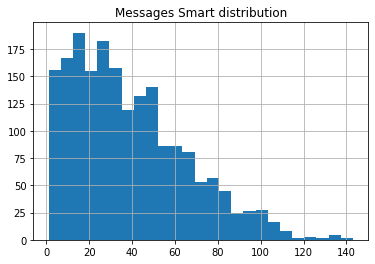

In [86]:
messages_group.loc[messages_group['tarif'] == 'smart', 'messages'].hist(bins=25)
plt.title('Messages Smart distribution')

In [87]:
variance_message_smart = np.var(messages_group.loc[messages_group['tarif'] == 'smart', 'messages'], ddof=1)
variance_message_smart

717.5942011753547

In [88]:
std_message_smart = math.sqrt(variance_message_smart)
std_message_smart

26.787948804926344

In [89]:
mean_message_smart = messages_group.loc[messages_group['tarif'] == 'smart', 'messages'].mean()
mean_message_smart

38.71644120707596

In [90]:
messages_group.loc[messages_group['tarif'] == 'smart', 'messages'].describe()

count    1922.000000
mean       38.716441
std        26.787949
min         1.000000
25%        17.000000
50%        34.000000
75%        55.000000
max       143.000000
Name: messages, dtype: float64

Поиск среднего, дисперсии и стандартного отклонения по смс для тарифа ультра 

Text(0.5, 1.0, 'Messages Ultra distribution')

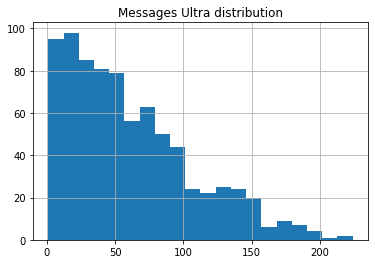

In [91]:
messages_group.loc[messages_group['tarif'] == 'ultra', 'messages'].hist(bins=20)
plt.title('Messages Ultra distribution')

In [92]:
variance_message_ultra = np.var(messages_group.loc[messages_group['tarif'] == 'ultra', 'messages'], ddof=1)
variance_message_ultra

2109.6591828652

In [93]:
std_message_ultra = np.std(messages_group.loc[messages_group['tarif'] == 'ultra', 'messages'], ddof=1)
std_message_ultra

45.931026364160424

In [94]:
mean_message_ultra = messages_group.loc[messages_group['tarif'] == 'ultra', 'messages'].mean()
mean_message_ultra

61.161006289308176

In [95]:
messages_group.loc[messages_group['tarif'] == 'ultra', 'messages'].describe()

count    795.000000
mean      61.161006
std       45.931026
min        1.000000
25%       24.000000
50%       51.000000
75%       87.500000
max      224.000000
Name: messages, dtype: float64

По гистограмам можно сказать, что пользователи неактивно используют сообщения, пользователи тарифа смарт в среднем отправляют не более 40 сообщений в месяц, а пользователи тарифа ультра не более 60

Расчет для интернета

In [96]:
internet_group

,user_id,month,mb_used,gb_used,tarif,gb_used_for_company,paid_gigabytes,gb_over_tarif,overprice_per_gb,final_overprice_internet
0,1000,5,2253.49,2.20,ultra,3,30,0,150,0
1,1000,6,23233.77,22.69,ultra,23,30,0,150,0
2,1000,7,14003.64,13.68,ultra,14,30,0,150,0
3,1000,8,14055.93,13.73,ultra,14,30,0,150,0
4,1000,9,14568.91,14.23,ultra,15,30,0,150,0
...,...,...,...,...,...,...,...,...,...,...
3198,1498,10,20579.36,20.10,smart,21,15,6,200,1200
3199,1499,9,1845.75,1.80,smart,2,15,0,200,0
3200,1499,10,17788.51,17.37,smart,18,15,3,200,600
3201,1499,11,17963.31,17.54,smart,18,15,3,200,600


Text(0.5, 1.0, 'Internet Smart distribution')

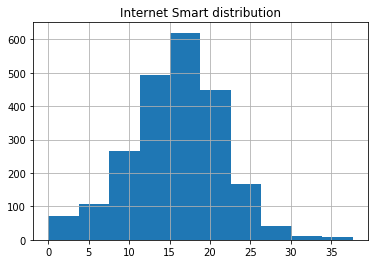

In [97]:
internet_group.loc[internet_group['tarif'] == 'smart', 'gb_used'].hist()
plt.title('Internet Smart distribution')

In [98]:
variance_internet_smart = np.var(internet_group.loc[internet_group['tarif'] == 'smart', 'gb_used'], ddof=1)
variance_internet_smart

32.76859998442084

In [99]:
std_internet_smart = np.std(internet_group.loc[internet_group['tarif'] == 'smart', 'gb_used'], ddof=1)
std_internet_smart

5.724386428642011

In [100]:
mean_internet_smart = internet_group.loc[internet_group['tarif'] == 'smart', 'gb_used'].mean()
mean_internet_smart

15.835713644524237

In [101]:
internet_group.loc[internet_group['tarif'] == 'smart', 'gb_used'].describe()

count    2228.000000
mean       15.835714
std         5.724386
min         0.000000
25%        12.350000
50%        16.120000
75%        19.572500
max        37.650000
Name: gb_used, dtype: float64

Расчет для пользователей тарифа ультра

Text(0.5, 1.0, 'Internet Ultra distribution')

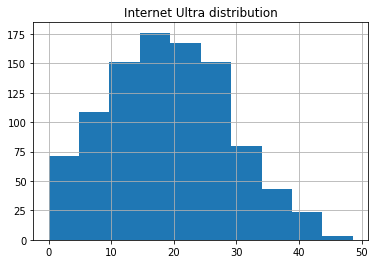

In [102]:
internet_group.loc[internet_group['tarif'] == 'ultra', 'gb_used'].hist()
plt.title('Internet Ultra distribution')

In [103]:
variance_internet_ultra = np.var(internet_group.loc[internet_group['tarif'] == 'ultra', 'gb_used'], ddof=1)
variance_internet_ultra

94.28253407950298

In [104]:
std_internet_ultra = np.std(internet_group.loc[internet_group['tarif'] == 'ultra', 'gb_used'], ddof=1)
std_internet_ultra

9.70991936524207

In [105]:
mean_internet_ultra = internet_group.loc[internet_group['tarif'] == 'ultra', 'gb_used'].mean()
mean_internet_ultra

19.20751794871795

In [106]:
internet_group.loc[internet_group['tarif'] == 'ultra', 'gb_used'].describe()

count    975.000000
mean      19.207518
std        9.709919
min        0.000000
25%       11.730000
50%       18.940000
75%       26.270000
max       48.580000
Name: gb_used, dtype: float64

По гистограмме расспределения для обоих тарифов похожи на нормальные, также видно, что пользователи тарифа смарт в основном используют около 15 гб трафика, то есть весь оплаченный объем, а пользователи тарифа ультра используют в среднем около 20 гб трафика, то есть меньше, чем у них оплачено. Также стоит отметить, что пользователи есть пользователи, которые используют значительно больше трафика, чем изначально оплатили

Формулировка гипотез:
Нулевая гипотеза: Средние выручки тарифов смарт и ультра равны.
Альтернативная гипотеза: Средние выручки тарифов смарт и ультра различаются.

In [107]:
final_group

,user_id,month,"(final_overprice_for_calls, )",final_overprice_for_messages,final_overprice_internet,tarif,abonent_payments,company_profit
0,1000,5,0.0,0.0,0.0,ultra,1950,1950.0
1,1000,6,0.0,0.0,0.0,ultra,1950,1950.0
2,1000,7,0.0,0.0,0.0,ultra,1950,1950.0
3,1000,8,0.0,0.0,0.0,ultra,1950,1950.0
4,1000,9,0.0,0.0,0.0,ultra,1950,1950.0
...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,400.0,smart,550,950.0
3210,1489,10,0.0,0.0,1000.0,smart,550,1550.0
3211,1489,11,0.0,0.0,600.0,smart,550,1150.0
3212,1489,12,0.0,0.0,400.0,smart,550,950.0


In [108]:
smart_profit = final_group.loc[final_group['tarif'] == 'smart', 'company_profit']
ultra_profit =  final_group.loc[final_group['tarif'] == 'ultra', 'company_profit']
alpha = 0.05
results = st.ttest_ind(smart_profit, ultra_profit)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 5.509138950507725e-178
Отвергаем нулевую гипотезу


Статистический тест отверг нулевую гипотезу, значит средние выручки тарифов смарт и ультра различаются

In [109]:
h = users.loc[:,['user_id', 'city']]
h

,user_id,city
0,1000,Краснодар
1,1001,Москва
2,1002,Стерлитамак
3,1003,Москва
4,1004,Новокузнецк
...,...,...
495,1495,Иркутск
496,1496,Вологда
497,1497,Челябинск
498,1498,Владикавказ


In [110]:
g = final_group.merge(h, how='inner')
g

,user_id,month,"(final_overprice_for_calls, )",final_overprice_for_messages,final_overprice_internet,tarif,abonent_payments,company_profit,city
0,1000,5,0.0,0.0,0.0,ultra,1950,1950.0,Краснодар
1,1000,6,0.0,0.0,0.0,ultra,1950,1950.0,Краснодар
2,1000,7,0.0,0.0,0.0,ultra,1950,1950.0,Краснодар
3,1000,8,0.0,0.0,0.0,ultra,1950,1950.0,Краснодар
4,1000,9,0.0,0.0,0.0,ultra,1950,1950.0,Краснодар
...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,0.0,0.0,smart,550,550.0,Санкт-Петербург
3210,1489,9,0.0,0.0,400.0,smart,550,950.0,Санкт-Петербург
3211,1489,10,0.0,0.0,1000.0,smart,550,1550.0,Санкт-Петербург
3212,1489,11,0.0,0.0,600.0,smart,550,1150.0,Санкт-Петербург


Обработаем столбец с городами

In [111]:
def low(string):
    return string.lower()

In [112]:
g['city'] = g['city'].apply(low)
g

,user_id,month,"(final_overprice_for_calls, )",final_overprice_for_messages,final_overprice_internet,tarif,abonent_payments,company_profit,city
0,1000,5,0.0,0.0,0.0,ultra,1950,1950.0,краснодар
1,1000,6,0.0,0.0,0.0,ultra,1950,1950.0,краснодар
2,1000,7,0.0,0.0,0.0,ultra,1950,1950.0,краснодар
3,1000,8,0.0,0.0,0.0,ultra,1950,1950.0,краснодар
4,1000,9,0.0,0.0,0.0,ultra,1950,1950.0,краснодар
...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,0.0,0.0,smart,550,550.0,санкт-петербург
3210,1489,9,0.0,0.0,400.0,smart,550,950.0,санкт-петербург
3211,1489,10,0.0,0.0,1000.0,smart,550,1550.0,санкт-петербург
3212,1489,11,0.0,0.0,600.0,smart,550,1150.0,санкт-петербург


Формулировка гипотез:
Нулевая гипотеза: Средняя выручка пользователей из Москвы такая же, как и средняя выручка пользователей из других городов.
Альтернативная гипотеза: Средняя выручка пользователей из Москвы отличается от средней выручки пользователей из других городов

In [113]:
moscow_profit = g.loc[g['city'] == 'москва','company_profit']
other_profit = g.loc[g['city'] != 'москва','company_profit']
alpha = 0.05
results = st.ttest_ind(moscow_profit, other_profit)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.45881442879463374
Не получилось отвергнуть нулевую гипотезу


Статистический тест не отверг нулевую гипотезу, гипотеза не опроверглась и не подтвердилась

При помощи статистического теста была отвергнута гипотеза о равенстве средних прибылей для тарифов смарт и ультра, надо рассмотреть этот момент

In [114]:
describe_smart = final_group.loc[final_group['tarif'] == 'smart', 'company_profit'].describe()
describe_smart

count    2229.000000
mean     1258.665321
std       801.401484
min       550.000000
25%       550.000000
50%       962.000000
75%      1736.000000
max      6614.000000
Name: company_profit, dtype: float64

In [115]:
describe_ultra = final_group.loc[final_group['tarif'] == 'ultra', 'company_profit'].describe()
describe_ultra

count     985.000000
mean     2070.304569
std       376.654762
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: company_profit, dtype: float64

Расчет прибыли в рамках стандартного отклонения для пользователя тарифа смарт

In [116]:
smart_profit_border = (round(describe_smart['count']*(describe_smart['mean'] - describe_smart['std']),2), 
                            round(describe_smart['count']*(describe_smart['mean'] + describe_smart['std']),2))
print('Граница прибыли для среднего пользователя тарифа смарт', smart_profit_border)
print('Нижняя граница {}'.format(smart_profit_border[0]))
print('Прибыль за год {}'.format(round(describe_smart['mean']*describe_smart['count'], 2)))
print('Верхняя граница {}'.format(smart_profit_border[1]))

Граница прибыли для среднего пользователя тарифа смарт (1019241.09, 4591888.91)
Нижняя граница 1019241.09
Прибыль за год 2805565.0
Верхняя граница 4591888.91


Расчет прибыли в рамках стандартного отклонения пользователя тарифа ультра

In [117]:
ultra_profit_border = (round(describe_ultra['count']*(describe_ultra['mean'] - describe_ultra['std']),2), 
                            round(describe_ultra['count']*(describe_ultra['mean'] + describe_ultra['std']),2))
print('Граница прибыли для среднего пользователя тарифа ультра', ultra_profit_border)
print('Нижняя граница {}'.format(ultra_profit_border[0]))
print('Прибыль за год {}'.format(round(describe_ultra['mean']*describe_ultra['count'], 2)))
print('Верхняя граница {}'.format(ultra_profit_border[1]))

Граница прибыли для среднего пользователя тарифа ультра (1668245.06, 2410254.94)
Нижняя граница 1668245.06
Прибыль за год 2039250.0
Верхняя граница 2410254.94


Рассмотрение гипотетического случая, если бы тарифы имели одинаковое количество пользователей  и использовались одинаковое количество месяцев

In [118]:
compare_profit_border = (round(describe_smart['count']*(describe_ultra['mean'] - describe_ultra['std']),2), 
                            round(describe_smart['count']*(describe_ultra['mean'] + describe_ultra['std']),2))
print('Граница прибыли для среднего пользователя тарифа ультра', compare_profit_border)
print('Нижняя граница {}'.format(compare_profit_border[0]))
print('Прибыль за год {}'.format(round(describe_ultra['mean']*describe_smart['count'], 2)))
print('Верхняя граница {}'.format(compare_profit_border[1]))

Граница прибыли для среднего пользователя тарифа ультра (3775145.42, 5454272.35)
Нижняя граница 3775145.42
Прибыль за год 4614708.88
Верхняя граница 5454272.35


Общий вывод:
Статистический анализ выборки показал, что на данный момент тариф смарт приносит компании больше денег, чем тариф ультра, причин у этого несколько: 1. У тарифа смарт больше пользователей. 2. Пользователи тарифа смарт довольно часто превышают оплаченный рубеж гигабайтов интернета, в тарифе смарт за это предусмотрена существенная доплата. Однако если бы оба тарифа имели одинаковое количество пользователей и ими бы пользовались одинаковое количество месяцев, то тариф ультра был бы прибыльнее(годовая прибыль - 4.6 млн), чем смарт(годовая прибыль-2.8 млн).
Из этих соображений можно сделать вывод, что тариф смарт для компании на данный момент лучше, но тариф ультра может быть перспективнее.